# FSTlib demo

This library is a modified version of the pywrapfst python extension contained in the openfst-1.8.2 package
The original can be found at www.openfst.org

## I. Edit distance between two strings

First, let's define a symbol table over the alphabet {a,b}.

In [2]:
import fstlib

symbol_table = fstlib.SymbolTable()
symbol_table.add_symbol('-')
alphabet = ['a','b']
for s in alphabet:
    symbol_table.add_symbol(s)

Then we define two finite-state acceptors (FSAs) containing the strings "aba"...

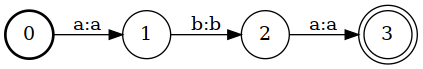

In [4]:
s1 = fstlib.factory.from_string("aba", isymbols=symbol_table, osymbols=symbol_table)
s1

...and "bb":

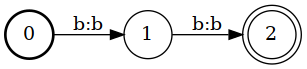

In [5]:
s2 = fstlib.factory.from_string("bb", isymbols=symbol_table, osymbols=symbol_table)
s2

Next we define the edit distance transducer T:

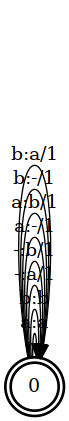

In [6]:
T = fstlib.Fst()
T.set_input_symbols(symbol_table)
T.set_output_symbols(symbol_table)
T.add_state()
T.set_final(0,0)
T.set_start(0)
T.add_arcs(0, [(s, s, 0, 0) for i,s in symbol_table if s!='-'])
T.add_arcs(0, [(s, t, 1, 0) for i,s in symbol_table for j,t in symbol_table if s!=t])

We can now build the composition of the first FSA with T and the second FSA:

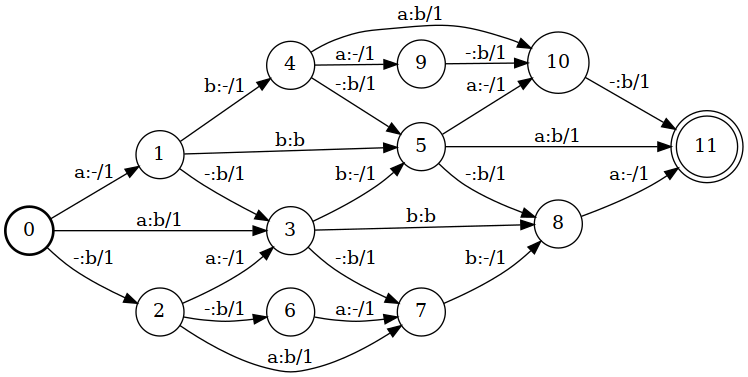

In [8]:
K = s1 * T * s2
K

Finally, we run the shortest path algorithm to determine the edit distance:

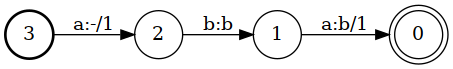

In [10]:

fstlib.shortestpath(K, nshortest=1)

## II. The occasionally unfair casino

Here we play the HMM textbook example "the occasionally unfair casino" with FSTs. 

The alphabet consists of "head" or "tail" (input) and "fair" or "unfair" (output) estimates: Sigma={H,T,f,u}.

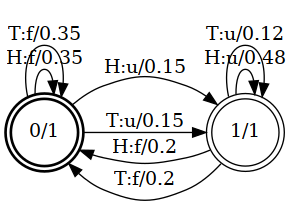

In [12]:
#%% imports
import os
import sys
import numpy as np
import fstlib

#%% create symbol table
symbols = ['H','T', 'f', 'u'] # head, tail, fair, unfair
symbol_table = fstlib.SymbolTable()
symbol_table.add_symbol('<eps>')
for s in symbols:
	symbol_table.add_symbol(s)


#%% create casino HMM
hmm = fstlib.Fst(arc_type='standard')
hmm.set_input_symbols(symbol_table)
hmm.set_output_symbols(symbol_table)
hmm.add_states(2)
hmm.set_start(0)
hmm.set_final(0,0)
hmm.set_final(1,0)
hmm.add_arc(0,('H','f',-np.log(0.35),0))
hmm.add_arc(0,('T','f',-np.log(0.35),0))
hmm.add_arc(0,('H','u',-np.log(0.15),1))
hmm.add_arc(0,('T','u',-np.log(0.15),1))
hmm.add_arc(1,('H','u',-np.log(0.48),1))
hmm.add_arc(1,('T','u',-np.log(0.12),1))
hmm.add_arc(1,('H','f',-np.log(0.2),0))
hmm.add_arc(1,('T','f',-np.log(0.2),0))
assert(hmm.verify())
hmm.to_real()
#print(hmm.to_real())


Next we define an input sequence of observed "head" or "tail" coin flips.

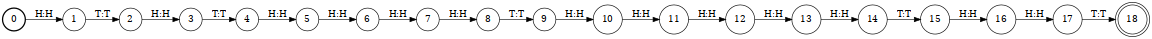

In [15]:
#%% create data
#seq = 'HHTHTHTHHHHHHTHHHHHHHTHTHHTHT'
seq = 'HTHTHHHHTHHHHHTHHT'
seqfsa = fstlib.factory.from_string(seq, arc_type='standard', isymbols=symbol_table, osymbols=symbol_table)
seqfsa.verify()
seqfsa

And "apply" the sequence of observables to the HMM through composition, thereby unrolling it:

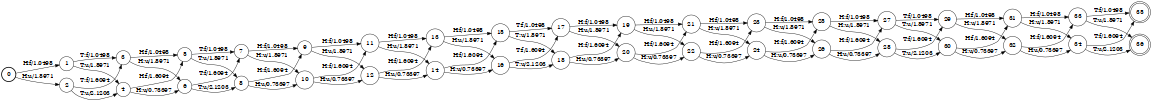

In [16]:
#%% Build HMM
unrolled = fstlib.compose(seqfsa, hmm)
unrolled

We then use the shortest path (Viterbi) algorithm to find the most likely state sequence.

In [18]:
#%% Viterbi solution
sp = fstlib.determinize(fstlib.shortestpath(unrolled))
sp


In [ ]:
fstlib.tools.strings(sp)

#%% MAP solution
posterior = fstlib.algos.posterior_decoding(unrolled.project('output'))

map = fstlib.determinize(fstlib.shortestpath(fstlib.arcmap(posterior, map_type='to_standard')))
fstlib.tools.strings(map)
